### TODO:
- Bayesian opt for hyperparameter selection.
- Look at where model is getting things wrong. Make function that plots largest/pathological errors.
- Look at LBM paper for error.

### Done/dismissed:
- Try demeaning all series? - doesn't work well.
- Why do plots have such different proportions of houses? - because three homes have data for *all* time periods.
- Changed kettle on_power_threshold to 1500 (from 2000) since it wasn't catching activations for house 3.
- Figure out why house 3/5/20 has inverse fridge pattern. - not sure but can look into it later

In [1]:
from __future__ import division

from utils import *
from create_data import *
from build_models import *

import os
import sys
import pandas as pd
import numpy as np
from collections import OrderedDict
import time
from datetime import datetime, date, timedelta
from dateutil.parser import parse
import re

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# from ggplot import *

import keras
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint, LambdaCallback
from keras.utils import plot_model
from keras import regularizers

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

%matplotlib inline
matplotlib.style.use('ggplot')

Using TensorFlow backend.


In [2]:
dir_proj = '/Users/sipola/Google Drive/education/coursework/graduate/edinburgh/dissertation/thesis'
dir_data = os.path.join(dir_proj, 'data')
dir_for_model = os.path.join(dir_data, 'for_model')
dir_for_model_real = os.path.join(dir_for_model, 'real')
dir_for_model_synth = os.path.join(dir_for_model, 'synthetic')
dir_models = os.path.join(dir_data, 'models')
dir_run = os.path.join(dir_proj, 'run', str(date.today()))
path_daily_stats = os.path.join(dir_data, 'stats_by_day.pkl')

In [3]:
N_PER_DAY = 14400  # 24 * 60 * 60 / 6
HOUSE_IDS = range(1, 22); HOUSE_IDS.remove(14)  # no house 14
HOUSE_IDS_TEST = [2,9,20]
HOUSE_IDS_TRAIN_VAL = [house_id for house_id in HOUSE_IDS if house_id not in HOUSE_IDS_TEST]
# HOUSE_IDS_SOLAR = [3,11,21]  # according to paper
HOUSE_IDS_SOLAR = [1,11,21]  # according to inspection
HOUSE_IDS_NOT_SOLAR = [house_id for house_id in HOUSE_IDS if house_id not in HOUSE_IDS_SOLAR]
# TRAIN_VAL_DATE_MAX = date(2015,2,28)
APP_NAMES = ['fridge', 'kettle', 'washing machine', 'dishwasher', 'microwave']
TRAIN_DTS = np.load(os.path.join(dir_for_model_synth, 'train_dts.npy'))

In [4]:
take_diff = False
# val_prop = 0.2
train_dates = [dt.date() for dt in TRAIN_DTS]
extreme_percentile_cutoff = 100

In [17]:
modeling_group_name = '2017-07-02'
target_type = 'energy'
app_names = ['kettle']
# app_names = list(APP_NAMES)

Y_key = 'Y1' if target_type=='energy' else 'Y2'

app_idx = []
for app_name in app_names:
    app_idx.append(APP_NAMES.index(app_name))

dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
model_files = get_model_files(dir_models_set)

history_all = []
params_all = []

for model_name in model_files:
    
    history_df = pd.read_csv(os.path.join(dir_models_set, model_name, 'history.csv'))
    params_df = pd.read_csv(os.path.join(dir_models_set, model_name, 'params.csv'),
                            header=None,
                            names=['param', 'value'])
    
    history_df['model'] = model_name
    params_df['model'] = model_name    
    
    history_all.append(history_df)
    params_all.append(params_df)
    
    # print model_name
    # print params_df

    # plot_errors(history_df, figsize=(11,5))
    # plt.show()
    
params_all = pd.concat(params_all)
history_all = pd.concat(history_all)

# print all_history
params_wide = params_all.pivot(index='model', columns='param')
history_best = history_all.groupby('model').agg({
    'loss': min,
    'val_loss': min,
    'runtime': min,
    'epoch': len
})

hist_and_params = history_best.join(params_wide)

hist_and_params.sort_values('val_loss', inplace=True)
# hist_and_params.to_csv('tmp.csv')

hist_and_params
# print params_all

IOError: File /Users/sipola/Google Drive/education/coursework/graduate/edinburgh/dissertation/thesis/data/models/2017-07-02/energy/kettle/model_0/history.csv does not exist

In [42]:
# Load best model
best_model_name = hist_and_params.loc[hist_and_params['loss']==hist_and_params['loss'].min()].index.values[0]
dir_this_model = os.path.join(dir_models_set, best_model_name, 'weights.hdf5')
model = load_model(os.path.join(dir_models_set, best_model_name, 'weights.hdf5'))
# model = load_model('/Users/sipola/Google Drive/education/coursework/graduate/edinburgh/dissertation/thesis/data/models/2017-06-28/fridge/model_11/weights.hdf5')

In [151]:
target_scaler = pickle.load(open(os.path.join(dir_this_model, 'target_scaler.pkl'), 'rb'))

mask = np.in1d(all_data['val']['x_house'], HOUSE_IDS_TEST)
for i in range(2):
    val_type = 'unseen homes' if i==0 else 'unseen times'
    X_val_fit = reshape_as_tensor(all_data['val']['X'][mask])
    Y_val_fit = target_scaler.transform(all_data['val'][Y_key][:,app_idx][mask])
    model.evaluate(X_val_fit, Y_val_fit)
    mask = ~mask

400/400 [==============================] - 0s     


In [112]:
# app_idx2 = 2
# app_idx2 = list(app_idx)
sub_app_idx = 0
if len(app_idx) == 1:
    sub_app_idx = 0
y_val = val_data[Y_key][:,app_idx][:,sub_app_idx]
y_hat = target_scaler.inverse_transform(model.predict(reshape_as_tensor(val_data['X']))[:,sub_app_idx])
if all(y_hat[0] == y_hat):
    print 'all predicted values are the same!'

In [85]:
# plot_series(val_data[X_idx][1])

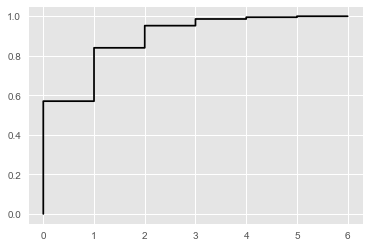

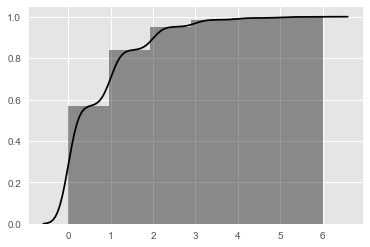

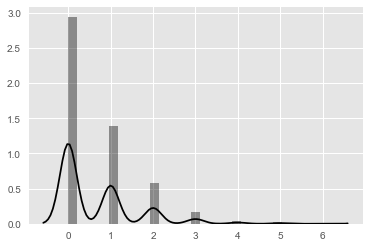

In [113]:
# sns.distplot(np.log2(y+1))
# sns.distplot(y, color='black')

value_to_plot = y_val

plot_empir_cum(value_to_plot)
plt.show()
sns.distplot(value_to_plot, color='black', hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
plt.show()
sns.distplot(value_to_plot, color='black')
plt.show()

# for i in range(Y.shape[1]):
#     ax = sns.distplot(Y[:,i], color='black')
#     ax.set_title('{}, actual'.format(APP_NAMES[i]))
#     plt.show()
#     ax = sns.distplot(Y_hat[:,i], color='black')
#     ax.set_title('{}, predicted'.format(APP_NAMES[i]))
#     plt.show() 

In [107]:
val_data['x_house']

array([20, 19, 20, ...,  5,  6, 19])

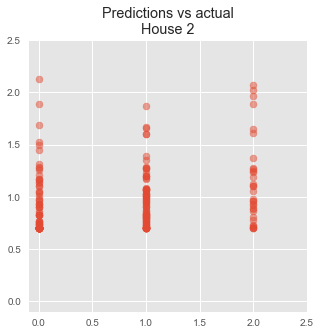

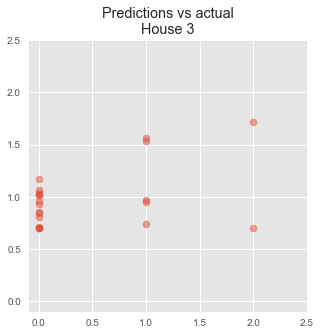

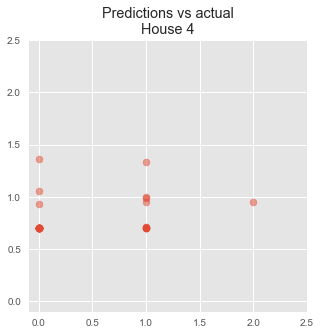

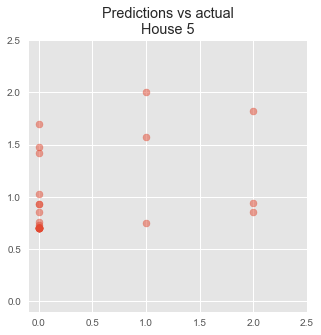

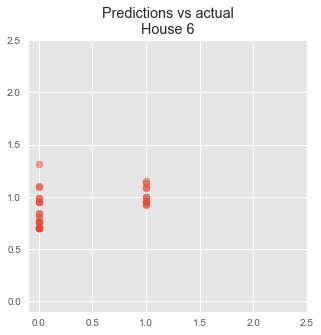

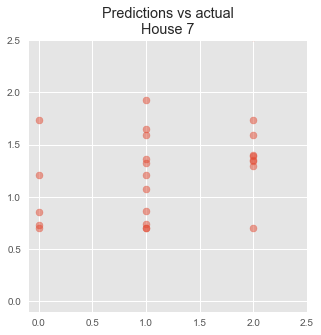

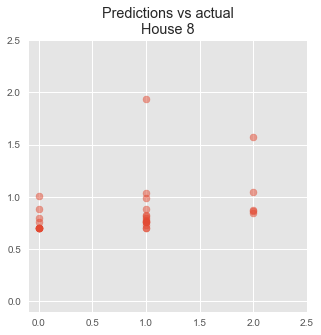

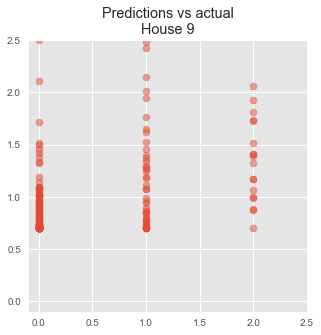

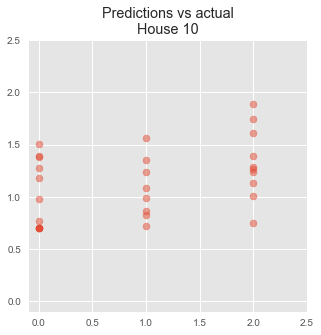

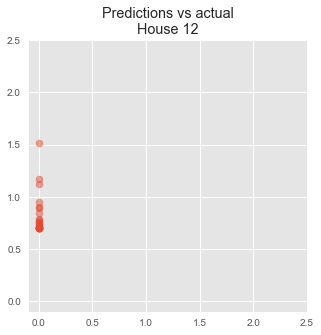

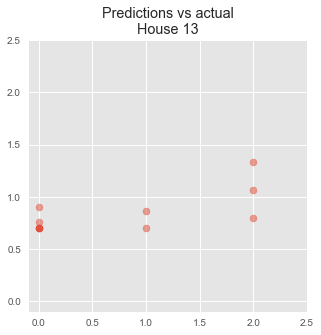

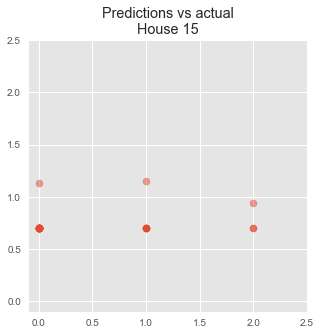

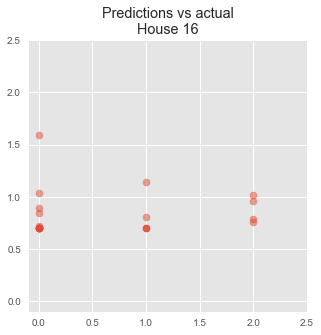

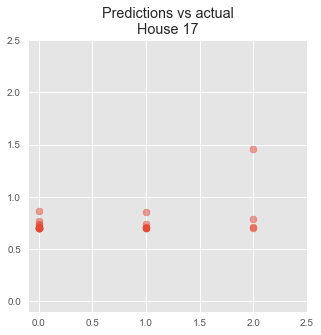

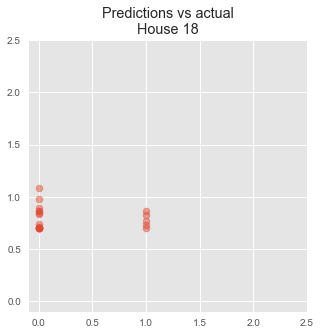

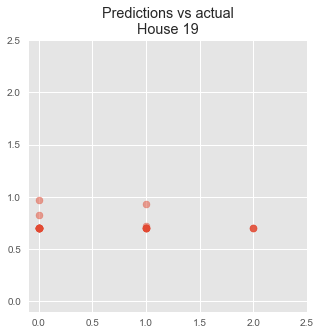

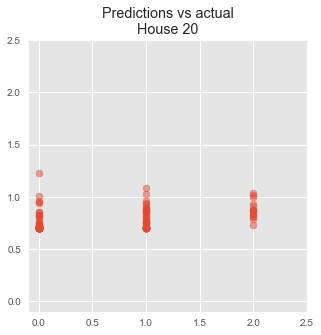

In [115]:
# # y_hat = dist_fun(y_hat, min_y, True)
# ax = sns.regplot(x=array_to_1d(y), y=array_to_1d(y_hat), color='black')
# ax.set_ylim(0,5)
# ax.set_xlim(0,5)

# colormap = plt.cm.Set1

x_house_val = val_data['x_house']

plot_together = False
figsize = (5,5)
plt_title = 'Predictions vs actual'
if plot_together:
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, title=plt_title)
# ax.set_color_cycle([colormap(i) for i in np.linspace(0, 1, len(app_names))])
for house_id in list(set(x_house_val)):
    if not plot_together:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, title=plt_title + '\nHouse {}'.format(house_id))
        ax.set_ylim(-0.1,2.5)
        ax.set_xlim(-0.1,2.5)
    y_hat_house = y_hat[x_house_val==house_id]
    y_val_house = y_val[x_house_val==house_id]
    ax.scatter(y_val_house, y_hat_house, alpha=0.5, label=house_id)
# plt.show()
# ax.set_ylim(0,2.5)
# ax.set_xlim(0,2.5)
if plot_together:
    ax.legend()
plt.show()
# print min(y_hat)


# i = 3
# y, y_hat = Y[:,i], Y_hat[:,i]
# fig = plt.figure()
# ax = fig.add_subplot(111, title='Test scatter')
# ax.scatter(y_hat, y, color='black', alpha=0.5)
# ax.set_ylim(0,5)
# ax.set_xlim(0,5)
# # print min(y_hat)

In [122]:
np.around(y_hat)

array([ 1.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32)

[[  0 561  12   1   1   0   0]
 [  0 246  23   1   2   0   0]
 [  0  91  20   2   0   0   0]
 [  0  18  15   1   0   0   0]
 [  0   7   1   1   0   0   0]
 [  0   0   4   1   0   0   0]
 [  0   1   0   0   0   0   0]]


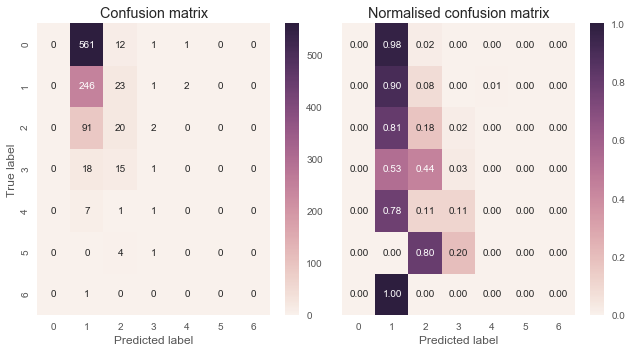

In [133]:
# Plot confusion matrix by using seaborn heatmap function
def plot_confusion_matrix(cm, normalize=False, classes=None, title='Confusion matrix'):
    """
    Credit: Data Mining and Exploration course at University of Edinburgh
    https://github.com/agamemnonc/dme/blob/master/04_Lab_4_Performance_evaluation_model_selection_solution.ipynb
    
    Plots a confusion matrix.
    
    If normalize is set to True, the rows of the confusion matrix are normalized so that they sum up to 1.
    
    """
    if normalize is True:
        cm = cm/cm.sum(axis=1)[:, np.newaxis]
        vmin, vmax = 0., 1.
        fmt = '.2f'
    else:
        vmin, vmax = None, None
        fmt = 'd'
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=vmin, vmax=vmax, 
                    annot=True, annot_kws={"fontsize":9}, fmt=fmt)
    else:
        sns.heatmap(cm, annot=True, fmt=fmt)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(y_val, np.around(y_hat))
print cm

# Your code goes here
fig = plt.figure(figsize=(9,5))
ax1 = fig.add_subplot(121)
plot_confusion_matrix(cm, normalize=False) # un-normalized
ax2 = fig.add_subplot(122)
plot_confusion_matrix(cm, normalize=True, title='Normalized confusion matrix') # normalized
ax2.get_yaxis().set_visible(False)
fig.tight_layout()

num extreme predictions: 4
extreme prediction 0
actual energy: [ 0.395835], predicted: [ 11.80590725]


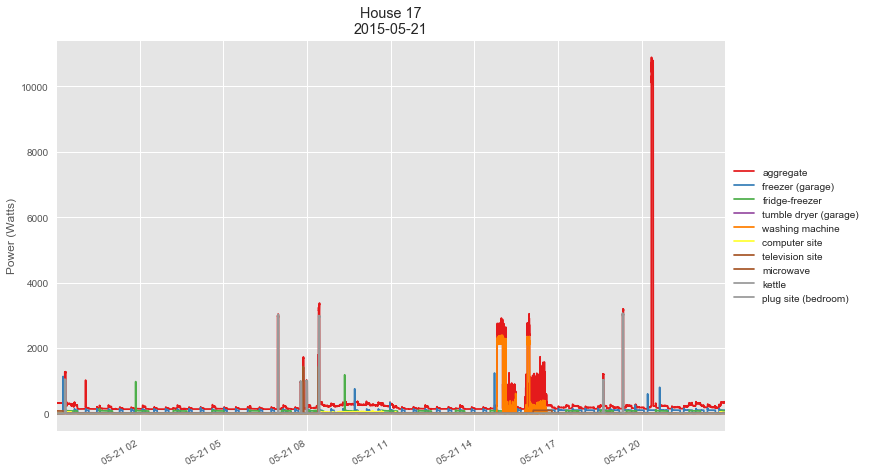

In [120]:
# Check where targets were normal but predictions were extreme.
extreme_y_hat_cutoff = 10

bad_idx = np.where(y_hat > extreme_y_hat_cutoff)[0]
print 'num extreme predictions: {}'.format(len(bad_idx))

i = 0  # change this
print 'extreme prediction {}'.format(i)

house_id = val_data[x_house_idx][bad_idx][i]
d = val_data[x_date_idx][bad_idx][i]
energy = val_data[Y_idx][:,app_idx][bad_idx][i]
print 'actual energy: {}, predicted: {}'.format(energy, y_hat[bad_idx][i])

plot_day(house_id, date_to_datetime(d), figsize=(15,8))

num extreme predictions: 2
extreme prediction 1
actual energy: [ 14.247415], predicted: [ 0.66881663]


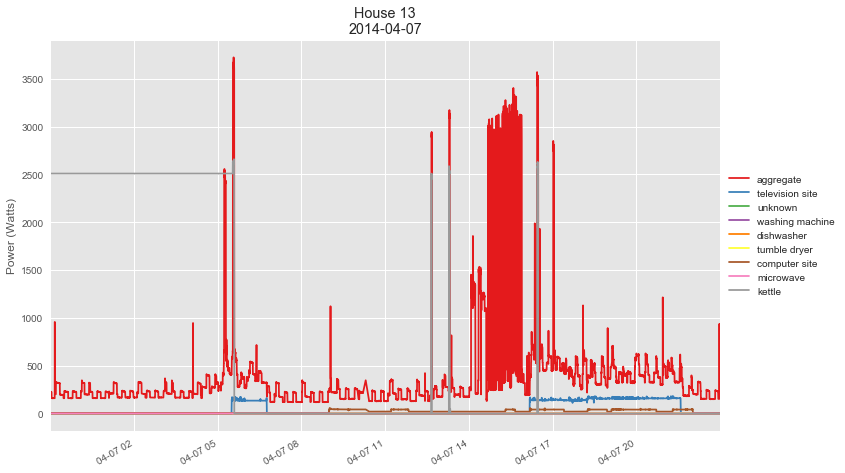

In [125]:
# Check where targets were extreme but predictions were too low.
extreme_y_cutoff = 2

bad_idx = np.where(y_val > extreme_y_cutoff)[0]
print 'num extreme predictions: {}'.format(len(bad_idx))

i = 1  # change this
print 'extreme prediction {}'.format(i)

house_id = val_data[x_house_idx][bad_idx][i]
d = val_data[x_date_idx][bad_idx][i]
energy = val_data[Y_idx][:,app_idx][bad_idx][i]
print 'actual energy: {}, predicted: {}'.format(energy, y_hat[bad_idx][i])

plot_day(house_id, date_to_datetime(d), figsize=(15,8))

In [ ]:
dir_refit_csv = os.path.join(dir_data, 'CLEAN_REFIT_081116')
dir_refit = os.path.join(dir_data, 'refit')
apps = pd.read_csv(os.path.join(dir_data, 'appliances.csv'))
app_dict = create_app_dict()
apps = apps_add_cols_from_patterns(apps, app_dict)
get_house_app_tuples, get_app_nums, get_app_name, is_a_target_app = create_app_funs(apps, app_dict, APP_NAMES)
load_app, load_ts, load_issues = create_load_funs(dir_refit)

path_daily_stats = os.path.join(dir_data, 'stats_by_day.pkl')
dstats = pd.read_pickle(path_daily_stats)
dstats = clean_daily_stats(dstats)

def get_df(house_id, use_app_names=False, dt_start=None, dt_end=None, include_issues=False):
    '''
    Plot time series of power data for each appliance, for specified house and date(time).
    '''
    
    # Load time series for house and get timestamps for specified date.
    ts_series = load_ts(house_id)
    
    # Add first column to df (timestamp).
    df = pd.DataFrame({'Unix': ts_series})
    
    # Add appliance columns.
    for app_num in range(10):
        if use_app_names:
            app_name = get_app_name(house_id, app_num)
        else:
            app_name = 'Appliance{}'.format(app_num) if app_num>0 else 'Aggregate'
        df[app_name] = load_app(house_id, app_num)
        
    if dt_start is not None:  # that is, if we don't want all dates
        ts_mask = get_ts_mask(ts_series, dt_start, dt_end)
        df = df.loc[ts_mask]
    
    if include_issues:
        # Add issues column.
        df['Issues'] = load_issues(house_id)
    
    return df


def plot_day(house_id, dt, savefile=None, figsize=(9,5), cols=None):
    '''
    Plot time series of power data for each appliance, for specified house and date(time).
    '''
    df = get_df(house_id, use_app_names=True, dt_start=dt)
    if cols is not None:
        cols += ['Unix']  # add Unix in case it wasn't included in cols
        cols = list(set(cols))
        df = df[cols]
    df['Time'] = pd.to_datetime(df['Unix'], unit='s', utc=True)
    df.set_index('Time', inplace=True)
    del df['Unix']
    
    # df = df.tz_localize('GMT').tz_convert('Europe/London')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    app_names = list(df)  # get columns from DataFrame
   
    # Set color map.
    colormap = plt.cm.Set1
    ax.set_color_cycle([colormap(i) for i in np.linspace(0, 1, len(app_names))])
    # ax = df.plot(figsize=figsize)
    for app_name in app_names:
        ax = df[app_name].plot(figsize=figsize)
    ax.set_title('House {}\n{}'.format(house_id, dt.date().strftime('%Y-%m-%d')))
    ax.set_xlabel('')
    ax.set_ylabel('Power (Watts)')
    # plt.xticks(np.arange(min(df.index), max(df.index)+1, 8.))

    # Put legend outside of plot.
    # https://stackoverflow.com/a/4701285/4794432
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # # Decrese legend font size.
    # fontP = FontProperties()
    # fontP.set_size('xx-small')

    if savefile is not None:
        plt.savefig(savefile)
    return ax

In [14]:
# val_data[X_idx][0]
i = 21
app_name = 'washing machine'

app_idx = APP_NAMES.index(app_name)

plot_series(val_data[X_idx][i])
house_id = val_data[x_house_idx][i]
d = val_data[x_date_idx][i]
energy1 = val_data[Y_idx][i][app_idx]
print house_id, d, energy1

plot_day(house_id, date_to_datetime(d))
energy2 = get_energy(dstats, house_id, d, get_app_nums(house_id, app_name))
print energy2

NameError: name 'val_data' is not defined